<h1>Analysis and manipulation of the circadian rhythm and zonation in single-cell data of mouse liver lobules 
</h1>
<h2>Reconstruction based on prior knowledge over pseudotime, cyclic and linear analysis</h2>
This tutorial aims to provide an overview of the scPrisma workflow, including the following steps:

1. Ordering the cells according to a given cyclic signal and linear signal(use prior knowledge for reconstruction).
2. Filtering of the linear signal.
3. Filteirng of the cyclic signal.
4. Enhancement of the linear signal.
5. Enhancement of the cyclic signal.


The example used in this tutorial is based on scRNA-seq data of mice liver samples which were sequenced at four equally-spaced time points along the day. <br />



In [1]:
import copy
import time
import matplotlib.pyplot as plt
import numpy as np
import scPrisma
import scanpy as sc
import torch
import pandas as pd
n_obs=1000

In [2]:
def read_cr_single_file_layer(path,layer_path,ZT="0" , n_obs=300):
    adata = sc.read_csv(path, delimiter='\t').T
    adata.var_names_make_unique()
    adata.obs_names_make_unique()
    adata.obs['ZT'] = ZT
    layers = cr_layer_read(layer_path)
    adata.obs['layer']=layers
    sc.pp.subsample(adata,n_obs=n_obs , random_state=123)
    return adata

def cr_layer_read(path):
    df = pd.read_csv(path, delimiter=',' , header=None)
    position_matrx = df.to_numpy()
    layers_array = np.zeros(position_matrx.shape[0])
    for i in range(position_matrx.shape[0]):
        layers_array[i]=position_matrx[i,:].argmax()
    return layers_array

def read_liver_data(n_obs=250):
    n_obs=int(n_obs/2)
    adata = read_cr_single_file_layer("liver/GSM4308343_UMI_tab_ZT00A.txt", layer_path="liver/ZT00A_reco.txt", ZT="0",
                                      n_obs=n_obs)
    adata.var_names_make_unique()
    adata.obs_names_make_unique()
    adata1 = read_cr_single_file_layer("liver/GSM4308344_UMI_tab_ZT00B.txt", layer_path="liver/ZT00B_reco.txt", ZT="0",
                                      n_obs=n_obs)
    adata1.var_names_make_unique()
    adata1.obs_names_make_unique()
    adata=adata.concatenate(adata1)
    adata.var_names_make_unique()
    adata.obs_names_make_unique()
    adata2 = read_cr_single_file_layer("liver/GSM4308346_UMI_tab_ZT06A.txt", layer_path="liver/ZT06A_reco.txt", ZT="6",
                                      n_obs=n_obs)
    adata2.obs_names_make_unique()
    adata2.var_names_make_unique()
    adata3 = read_cr_single_file_layer("liver/GSM4308347_UMI_tab_ZT06B.txt", layer_path="liver/ZT06B_reco.txt", ZT="6",
                                      n_obs=n_obs)
    adata3.obs_names_make_unique()
    adata3.var_names_make_unique()
    adata2=adata2.concatenate(adata3)
    adata2.var_names_make_unique()
    adata2.obs_names_make_unique()

    adata4 = read_cr_single_file_layer("liver/GSM4308348_UMI_tab_ZT12A.txt", layer_path="liver/ZT12A_reco.txt", ZT="12", n_obs=n_obs)
    adata4.var_names_make_unique()
    adata4.obs_names_make_unique()
    adata5 = read_cr_single_file_layer("liver/GSM4308349_UMI_tab_ZT12B.txt", layer_path="liver/ZT12B_reco.txt", ZT="12",
                                      n_obs=n_obs)
    adata5.var_names_make_unique()
    adata5.obs_names_make_unique()
    adata4=adata4.concatenate(adata5)
    adata4.var_names_make_unique()
    adata4.obs_names_make_unique()

    adata6 = read_cr_single_file_layer("liver/GSM4308351_UMI_tab_ZT18A.txt", layer_path="liver/ZT18A_reco.txt", ZT="18",
                                      n_obs=n_obs)
    adata6.var_names_make_unique()
    adata6.obs_names_make_unique()
    adata7 = read_cr_single_file_layer("liver/GSM4308352_UMI_tab_ZT18B.txt", layer_path="liver/ZT18B_reco.txt", ZT="18",
                                      n_obs=n_obs)
    adata7.var_names_make_unique()
    adata7.obs_names_make_unique()
    adata6=adata6.concatenate(adata7)
    adata6.var_names_make_unique()
    adata6.obs_names_make_unique()

    adata = adata.concatenate(adata2, adata4, adata6)
    adata.var_names_make_unique()
    adata.obs_names_make_unique()
    return adata


<h2>Data read and sorting according to "Zeitgeber Time" </h2> <br />
The function "sort_data_crit" sorts the data according to an observation of the field that is inserted as 'crit', in the order of 'crit_list'.

In [3]:
adata = read_liver_data(n_obs) #read data
adata = scPrisma.algorithms_torch.sort_data_crit(adata=copy.deepcopy(adata.copy()),crit='ZT',crit_list=['0','6','12','18']) #sort the data according to the timepoints
adata

/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/c

View of AnnData object with n_obs × n_vars = 4000 × 14812
    obs: 'ZT', 'layer', 'batch'

<h2>Standard pre-processing</h2> <br />
It is recomended to not scale the data to zero mean

In [4]:
#standard pre-processing
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.filter_genes_dispersion(adata, n_top_genes=7000)
orig_adata = copy.deepcopy(adata.copy())



/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


Plotting

/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


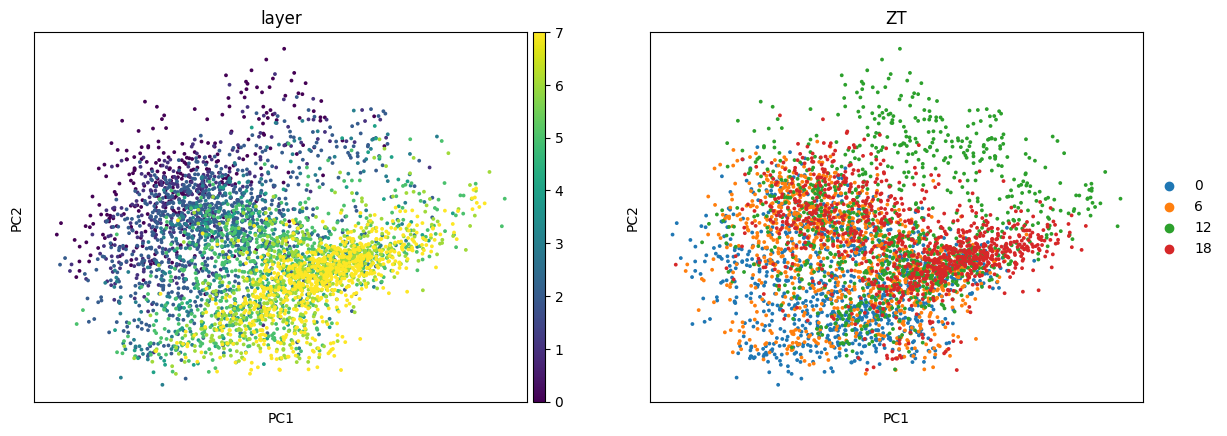

In [5]:
sc.pp.pca(adata)
sc.pl.pca(adata, color=['layer','ZT'])

<h2> Linear filtering</h2>
Sorting the data according to linear ordering, <b> it is important to shuffle the data before sorting</b> and performing the linear filtering.

6999
1
0
cuda
starting filtering
Iteration number: 1
torch.cuda.memory_allocated: 1.074327GB


/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


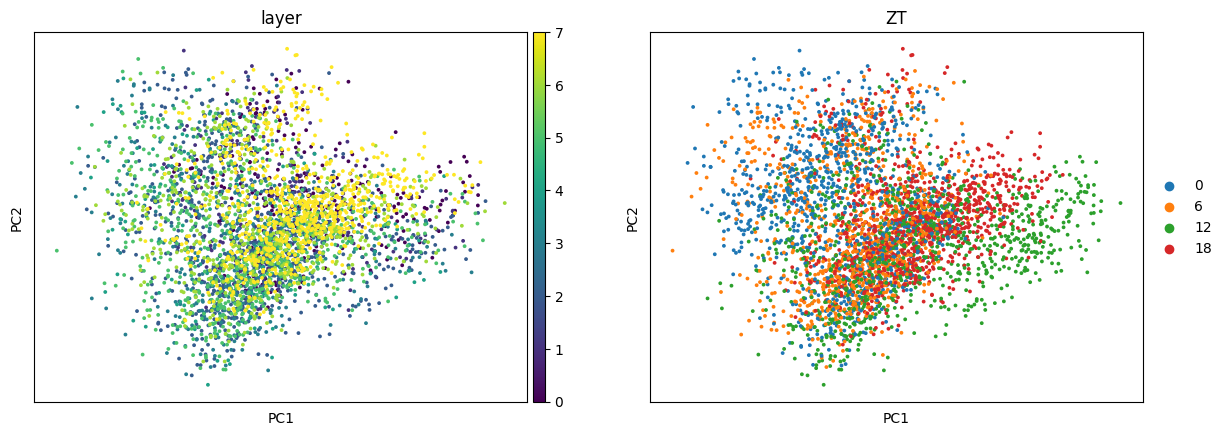

In [6]:
#linear filtering
linear_adata = copy.deepcopy(orig_adata.copy())
linear_adata = scPrisma.algorithms_torch.shuffle_adata(linear_adata)
linear_adata = scPrisma.algorithms_torch.sort_data_crit(adata=copy.deepcopy(linear_adata.copy()),crit='layer',crit_list=range(8)) 
#sort the data according to the lobule layers
adata_linear_filtered = copy.deepcopy(linear_adata.copy())
F1 = scPrisma.algorithms_torch.filter_linear_full_torch(adata_linear_filtered.X, regu=0 , iterNum=100 , method= 'numeric')
adata_linear_filtered.X = adata_linear_filtered.X * F1
sc.pp.pca(adata_linear_filtered)
sc.pl.pca(adata_linear_filtered, color=['layer','ZT'])

<h2> Cyclic filtering</h2>

0
cuda
starting filtering
Iteration number: 1
Iteration number: 101
Iteration number: 201
torch.cuda.memory_allocated: 1.074327GB


/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


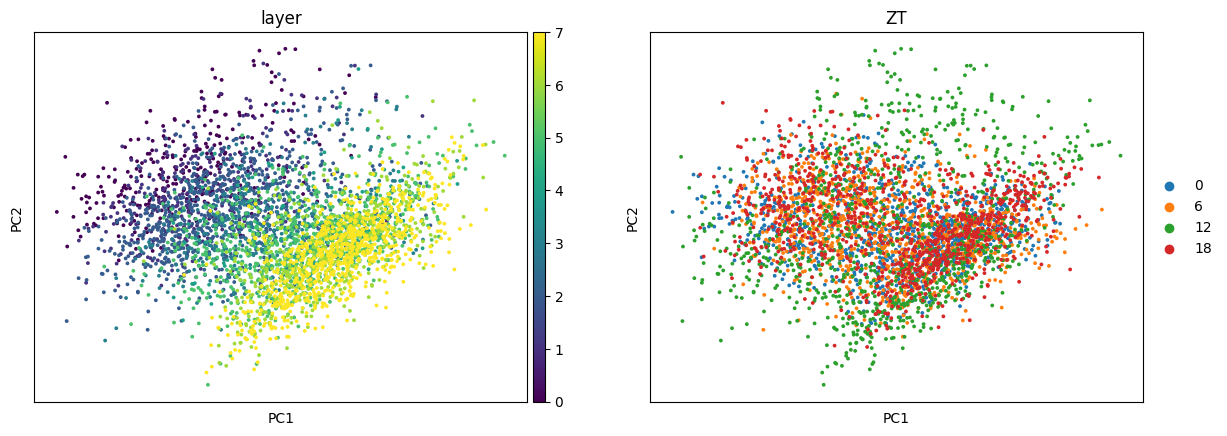

In [7]:
#cyclic filtering

adata_cyclic_filtered = copy.deepcopy(orig_adata.copy())
F = scPrisma.algorithms_torch.filtering_cyclic_torch(adata_cyclic_filtered.X, regu=0, iterNum=300, verbosity=25)
adata_cyclic_filtered.X = adata_cyclic_filtered.X * F
sc.pp.pca(adata_cyclic_filtered)
sc.pl.pca(adata_cyclic_filtered, color=['layer','ZT'])

<h2> Cyclic enhancement</h2>


Iteration number: 
1
starting enhancement on cuda
Iteration number: 1
torch.cuda.memory_allocated: 0.372882GB


/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


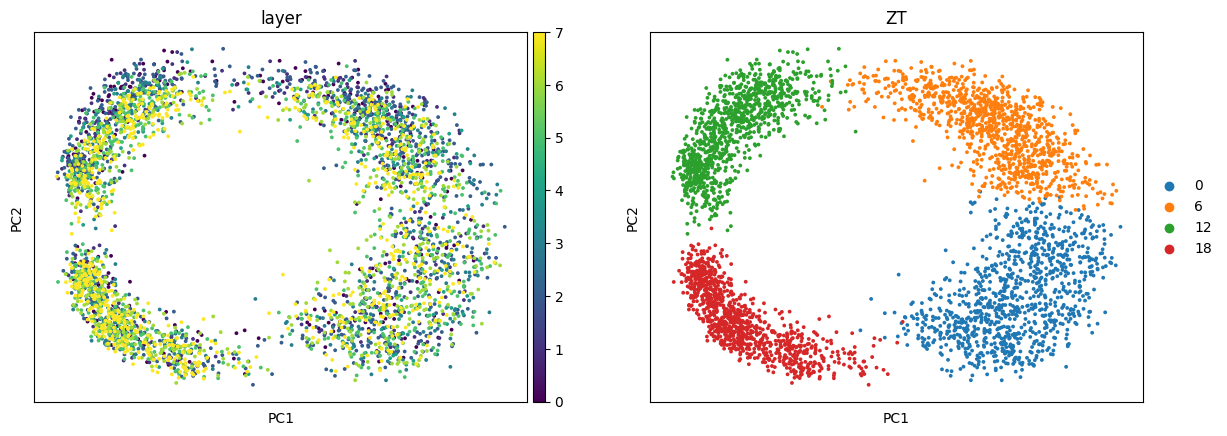

In [8]:
#cyclic enhancement
adata_cyclic_enhancment = copy.deepcopy(orig_adata.copy())
D = scPrisma.algorithms_torch.filter_cyclic_genes_torch(adata_cyclic_enhancment.X, regu=1,iterNum=25)
D = np.identity(D.shape[0])-D
adata_cyclic_enhancment.X = adata_cyclic_enhancment.X.dot(D)
F =scPrisma.algorithms_torch.enhancement_cyclic_torch(adata_cyclic_enhancment.X, regu=0.01 ,iterNum=100)
adata_cyclic_enhancment.X = adata_cyclic_enhancment.X * F
sc.pp.pca(adata_cyclic_enhancment)
sc.pl.pca(adata_cyclic_enhancment, color=['layer','ZT'])

<h2> Linear enhancement</h2>


Iteration number: 
1
Iteration number: 
26
0
cuda
starting filtering
Iteration number: 1
torch.cuda.memory_allocated: 0.641471GB


/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


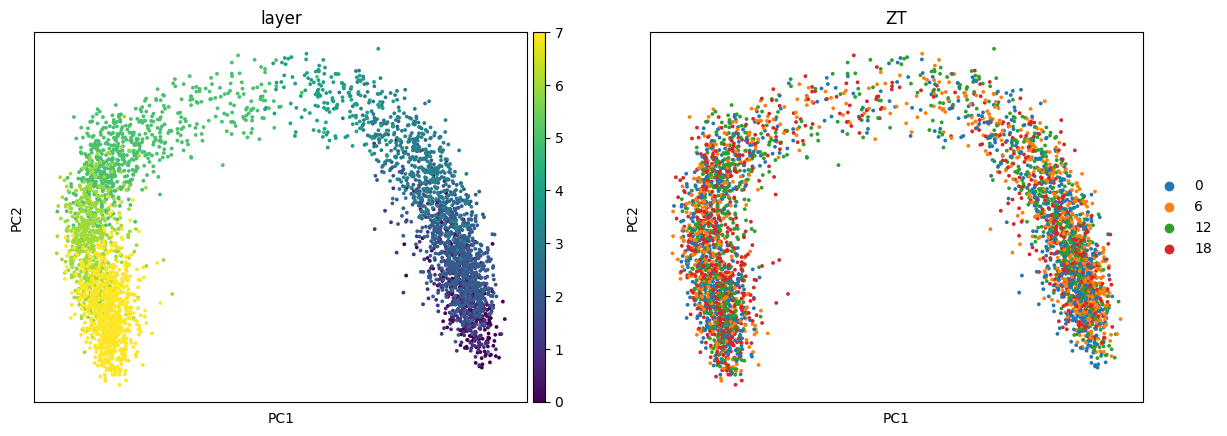

In [9]:
#linear enhancement
adata_linear_enhanced = linear_adata.copy()

D = scPrisma.algorithms_torch.filter_linear_genes_torch(adata_linear_enhanced.X,regu=1,method='numeric' , iterNum=50) #0.5
D1 = np.identity(D.shape[0])-D
adata_linear_enhanced.X = adata_linear_enhanced.X.dot(D1)
F_en = scPrisma.algorithms_torch.enhancement_linear_torch(adata_linear_enhanced.X, regu=0, iterNum=10 , method='numeric') # -0.01
adata_linear_enhanced.X = adata_linear_enhanced.X * F_en
sc.pp.pca(adata_linear_enhanced)
sc.pl.pca(adata_linear_enhanced, color=['layer','ZT'])

In [10]:
from sklearn import metrics

In [11]:
print("silhouette score between different timepoints:")
print("Raw data: "+str(metrics.silhouette_score(adata.obsm['X_pca'],adata.obs['ZT'])))
print("Linear enhanced: "+str(metrics.silhouette_score(adata_linear_enhanced.obsm['X_pca'],adata_linear_enhanced.obs['ZT'])))
print("Linear filtered: "+str(metrics.silhouette_score(adata_linear_filtered.obsm['X_pca'],adata_linear_filtered.obs['ZT'])))
print("Cyclic enhanced: "+str(metrics.silhouette_score(adata_cyclic_enhancment.obsm['X_pca'],adata_cyclic_enhancment.obs['ZT'])))
print("Cyclic filtered: "+str(metrics.silhouette_score(adata_cyclic_filtered.obsm['X_pca'],adata_cyclic_filtered.obs['ZT'])))


silhouette score between different timepoints:
Raw data: 0.05938878
Linear enhanced: 0.00643454
Linear filtered: 0.060301133
Cyclic enhanced: 0.3077044
Cyclic filtered: -0.005461171
